In [1]:
%pip install -Uqq fastbook

Note: you may need to restart the kernel to use updated packages.


In [1]:
from fastbook import *

/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
urls = search_images_ddg('bird photos', max_images=1)
len(urls), urls[0]

(1,
 'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg')

In [3]:
import time
filename = f"bird_{time.time_ns()}.jpg"
dest = Path(filename)
if not dest.exists(): download_url(urls[0], dest, show_progress=False)
dest

Path('bird_1749724758822987000.jpg')

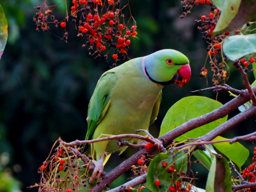

In [4]:
im = Image.open(dest)
im.to_thumb(256,256)

In [5]:
searches = 'forest', 'bird'
path = Path('bird_or_not')

# Always create base directory
path.mkdir(exist_ok=True, parents=True)

for o in searches:
    class_path = path/o  # bird_or_not/forest or bird_or_not/bird
    
    # Create class directory if missing
    class_path.mkdir(exist_ok=True, parents=True)
    
    # Only download if directory is empty
    if len(list(class_path.glob('*'))) == 0:
        print(f"Downloading {o} images...")
        results = search_images_ddg(f'{o} photo', max_images=200)
        download_images(class_path, urls=results)
        resize_images(class_path, max_size=400, dest=class_path)

/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


In [6]:
print("\nFinal directory status:")
for o in searches:
    class_path = path/o
    imgs = get_image_files(class_path)
    print(f"{o}: {len(imgs)} images")
    if len(imgs) > 0:
        print(f"  Sample: {imgs[0]}")


Final directory status:
forest: 190 images
  Sample: bird_or_not/forest/022daddc-ae56-466f-b6ba-3978a95535f4.jpg
bird: 189 images
  Sample: bird_or_not/bird/3c8ec780-66ff-493d-97c7-ae32b3f0f262.jpg


In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)

/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/Users/kennymodebelu/Documents/FastAI - Machine Learning/Lesson 1/is_this_a_bird?/.venv/lib/python3.9/site-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


In [8]:
# Check total images
image_files = get_image_files(path)
print(f"Total images found: {len(image_files)}")

# Check per category
for category in searches:
    cat_files = get_image_files(path/category)
    print(f"{category} images: {len(cat_files)}")

Total images found: 373
forest images: 186
bird images: 187


In [9]:
# Sample first 5 image paths
print("Sample image paths:")
for f in image_files[:5]:
    print(f)

Sample image paths:
bird_or_not/forest/022daddc-ae56-466f-b6ba-3978a95535f4.jpg
bird_or_not/forest/e05ec2c3-168f-4a67-ab7a-77b7c0915380.jpg
bird_or_not/forest/e2551a23-9a94-42e5-a639-9d3d501f6a0d.jpg
bird_or_not/forest/8f014d57-cc8f-434c-b985-e8cfdc65e04a.jpg
bird_or_not/forest/536d63dc-a6cc-4f75-9699-ea72d4ed1343.jpg


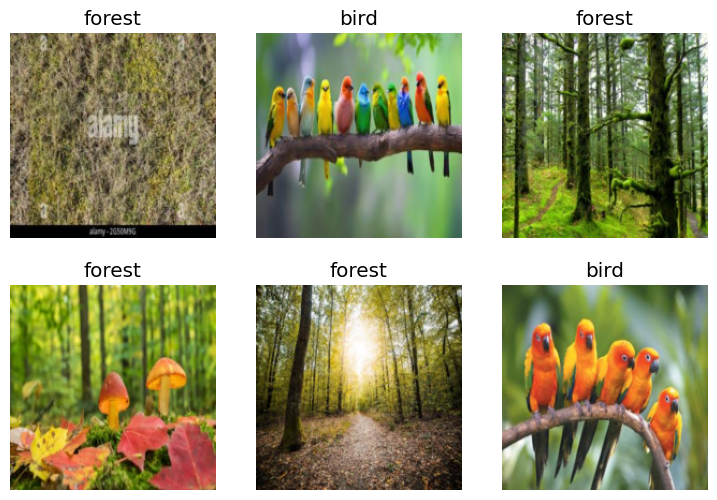

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/kennymodebelu/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:04<00:00, 9.96MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.801502,1.200035,0.216216,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.198037,0.373238,0.067568,00:05
1,0.130288,0.288766,0.081081,00:02
2,0.091778,0.262314,0.067568,00:02


In [13]:
is_bird,_,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]: .4f}")

This is a: bird.
Probability it's a bird:  1.0000
